In [62]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import njit
import matplotlib.pyplot as plt
from scipy.ndimage import laplace

class Molecule:
    def __init__(self, diffusion_rate, initial_condition='random', location=None, grid_size=(50, 50, 50)):
        self.diffusion_rate = diffusion_rate
        self.grid_size = grid_size
        
        if initial_condition == 'random':
            self.concentration = np.random.rand(*grid_size)
        elif initial_condition == 'linear_gradient':
            self.concentration = np.linspace(0, 1, grid_size[0]).reshape(-1, 1, 1)
            self.concentration = np.tile(self.concentration, (1, grid_size[1], grid_size[2]))
        elif initial_condition == 'localized' and location is not None:
            self.concentration = np.zeros(grid_size)
            self.concentration[location] = 1.0

'''@njit
def laplacian(u):
    laplacian_u = np.zeros_like(u)
    nx, ny, nz = u.shape
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                laplacian_u[i, j, k] = (
                    u[(i+1)%nx, j, k] + u[(i-1)%nx, j, k] +
                    u[i, (j+1)%ny, k] + u[i, (j-1)%ny, k] +
                    u[i, j, (k+1)%nz] + u[i, j, (k-1)%nz] -
                    6 * u[i, j, k]
                )
    return laplacian_u'''


class DiffusionSystem:
    def __init__(self, molecules, grid_size, time_step, total_time):
        self.molecules = molecules
        self.grid_size = grid_size
        self.time_step = time_step
        self.total_time = total_time
        self.grid_size_prod = np.prod(grid_size)
        self.y0 = np.hstack([molecule.concentration.ravel() for molecule in molecules])
        self.diffusion_rates = np.array([molecule.diffusion_rate for molecule in molecules])
        
    def diffusion_system(self, t, y):
        concentrations = []
        offset = 0
        for i, molecule in enumerate(self.molecules):
            C = y[offset:offset + self.grid_size_prod].reshape(self.grid_size)
            dC_dt = self.diffusion_rates[i] * laplace(C)
            concentrations.append(dC_dt.ravel())
            offset += self.grid_size_prod
        return np.concatenate(concentrations)

    def run_simulation(self):
        t_span = (0, self.total_time)
        t_eval = np.arange(0, self.total_time, self.time_step)
        
        solution = solve_ivp(
            self.diffusion_system, t_span, self.y0, method='RK45', t_eval=t_eval, vectorized=True
        )
        
        # Extract results and reshape concentrations
        results = []
        offset = 0
        for _ in self.molecules:
            concentration_sol = solution.y[offset:offset + self.grid_size_prod].reshape(self.grid_size + (len(t_eval),))
            results.append(concentration_sol)
            offset += self.grid_size_prod

        return results

    def visualize_slice(self, data, slice_index, title):
        plt.figure(figsize=(8, 6))
        plt.imshow(data[:, :, slice_index], cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar()
        plt.title(title)
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.show()

    def visualize_3d(self, data, title):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        x, y, z = np.indices(data.shape)
        ax.scatter(x, y, z, c=data.flatten(), cmap='viridis', marker='o')
        ax.set_title(title)
        plt.show()

Simulation completed in 0.18 seconds.


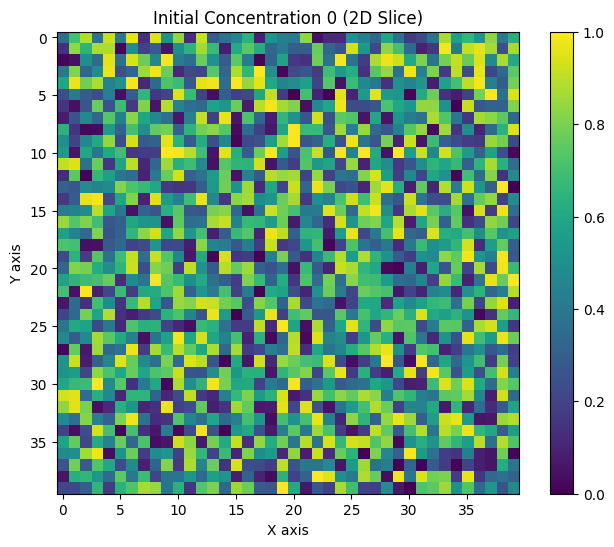

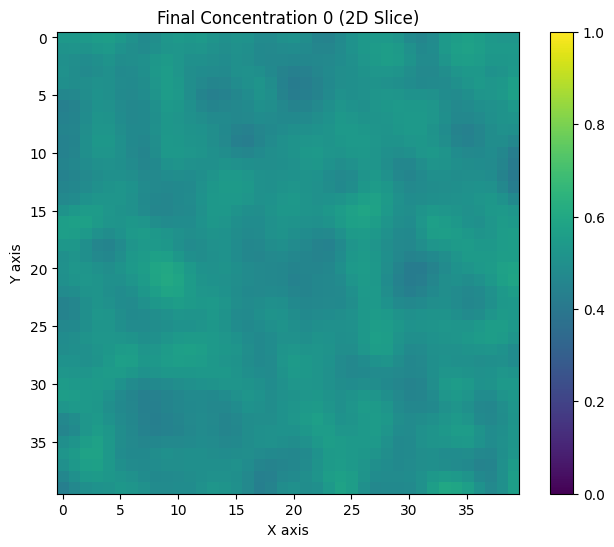

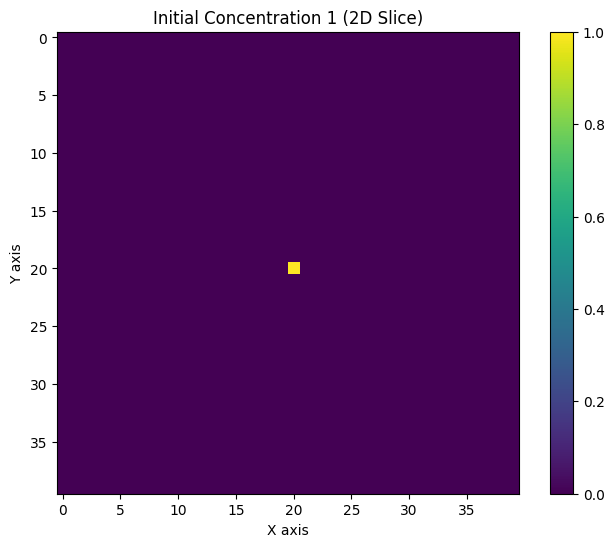

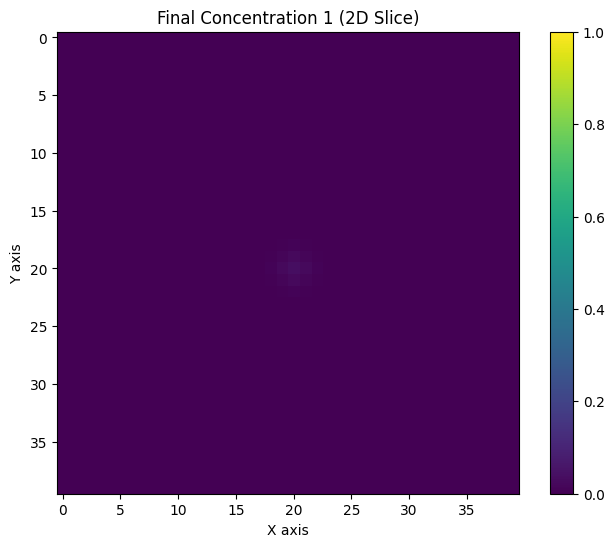

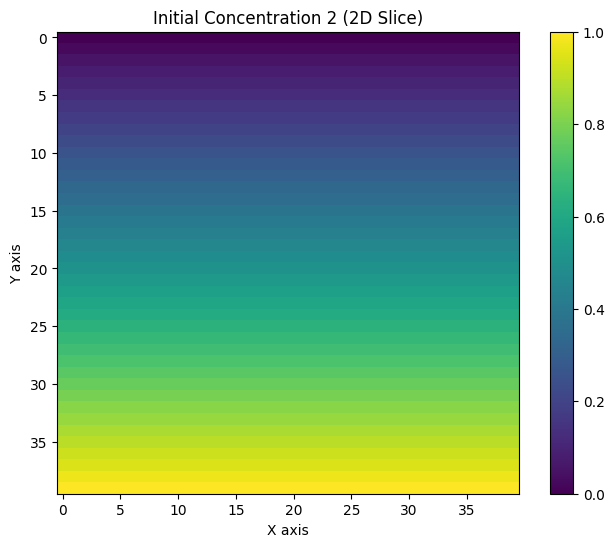

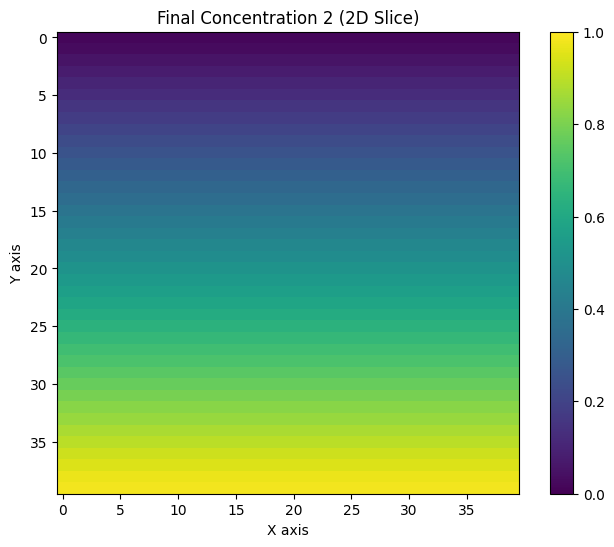

In [63]:
import time
# Example usage:
grid_size = (40, 40, 40)
diffusion_rate_A = 1.0
diffusion_rate_B = diffusion_rate_A
diffusion_rate_C = diffusion_rate_A
time_step = 0.1
total_time = 1

# Create molecules with different initial conditions
molecule_A = Molecule(diffusion_rate_A, initial_condition='random', grid_size=grid_size)
molecule_B = Molecule(diffusion_rate_B, initial_condition='localized', location=(20, 20, 20), grid_size=grid_size)
molecule_C = Molecule(diffusion_rate_C, initial_condition='linear_gradient', grid_size=grid_size)

# Create a diffusion system
diffusion_system = DiffusionSystem(
    [molecule_A, molecule_B, molecule_C],
    grid_size,
    time_step,
    total_time
)

start_time = time.time()
# Run the simulation
results = diffusion_system.run_simulation()
end_time = time.time()
print(f"Simulation completed in {end_time - start_time:.2f} seconds.")

for idx, result in enumerate(results): 
    diffusion_system.visualize_slice(result[..., 0], grid_size[2] // 2, f'Initial Concentration {idx} (2D Slice)')
    diffusion_system.visualize_slice(result[..., -1], grid_size[2] // 2, f'Final Concentration {idx} (2D Slice)')